<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flowers_Recognition's_optimal_approach(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hello 👋
####This repository will give you a simple approach (but an effective one) to code in PyTorch that can be used recursively for any other problems in Machine Learning/Deep Learning Field.


#####Unfortunately, the Ram crushes in the Colab, so I can't train it with PyTorch; if you have more ram, feel free to run this code, but if you don't have a powerful system to run it, you can run this code in [My Kaggle Notebook](https://www.kaggle.com/code/mralamdari/flowers-recognition-s-optimal-approach-PyTorch), there are more models with trainning results in this notebook and you can easily edit and run it.
#####You can get more details on this project and learn about object recognition on my article on medium; [How to do Object Recognition with PyTorch(Keras) the Easiest way](https://medium.com/@mr.alamdari/imagehow-to-do-object-recognition-with-PyTorch-keras-the-easiest-way-23c7ab9604c7)

# 1.Import Essential Libraris


In [ ]:
import os
import copy
import time
import torch
import warnings
import matplotlib
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

#2. Data
The Dataset in this project contains 4242 images of flowers; the data collection is based on the data Flickr, Google Images, and Yandex images, and it is used to recognize plants from the photo. There are five kinds of flowers: daisy, dandelion, rose, sunflower, and tulip, and each class has about 800 pictures of different sizes but not high resolutions. You can access the dataset here.

In PyTorch, you can readily do DataAugmentation and grow your dataset's size; since Neural Networks need more data to train, it will enhance the model's performance.

### Transformer

In [ ]:
path = '/content/flowers'

In [ ]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)

In [ ]:
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

### Train/Test/Val Split

In [ ]:
#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])

In [ ]:
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

In [ ]:
# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val_ds = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])


In [ ]:
train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True)

###Notice 1:
since there isn't enough ram to support all dataset1 + dataset2 + dataset3, I will only use train_val and test set as my train / val datasets.

In [ ]:
train = train_val
val = test

###Notice 2:
We need more data so we ignore test data for now and focus only on train/val data

In [ ]:
# train_val  ==> Original + dataset1 + dataset2 + dataset3
train_val_ds = torch.utils.data.ConcatDataset([
                                torchvision.datasets.ImageFolder(path, transform=transformer['original']),
                                # torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True)

batch_size = 32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, pin_memory=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, pin_memory=True, num_workers=2),
}

In [ ]:
len(train), len(val)

(11655, 1296)

### Data Loader

In [ ]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

In [ ]:
dataset_sizes

#### How ImBalance is ourdaset

In [ ]:
dic = {}
for cls in original.classes:
  dic[cls] = len(os.listdir(f'{path}/{cls}'))

samplesize = pd.DataFrame(dic, index=[0])
samplesize

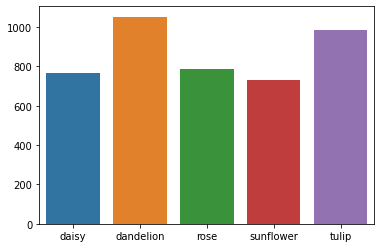

In [ ]:
sns.barplot(data=samplesize)

# 3.Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0876) tensor(0.8731)


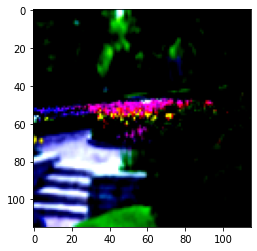

In [ ]:
z, _ = next(iter(data_loaders['test']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1441) tensor(0.9451)


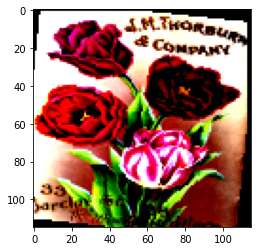

In [ ]:
z, _ = next(iter(data_loaders['val']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

In [ ]:
def plot_imgs(imgs, nrows=5, ncols=5):
  fig, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3))
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      img = matplotlib.image.imread(imgs[index][0])
      ax[row][col].imshow(img)
      ax[row][col].axis('off')
      ax[row][col].set_title(imgs[index][1], fontsize=15)
      index += 1

In [ ]:
def rand_imgs(original, img_folder=path, count=25):
  rand_imgs = []
  categories = original.classes
  for cat in categories:
    folder_path = f"{img_folder}/{cat}"
    imgs_list = os.listdir(folder_path)
    selected_imgs = np.random.choice(imgs_list, count//len(categories))
    rand_imgs.extend([(f'{folder_path}/{img_path}', cat) for img_path in selected_imgs])
  np.random.shuffle(rand_imgs)
  return rand_imgs

In [ ]:
my_imgs = rand_imgs(original, path, 15)

In [ ]:
plot_imgs(my_imgs, 5, 3)

In [ ]:
def plot_batch(data_loader):
  for imgs, labels in data_loader:
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(torchvision.utils.make_grid(imgs[:60], nrow=10).permute(1, 2, 0))
    ax.set_title('Augmented Images')
    break

In [ ]:
plot_batch(data_loaders['train'])

In [ ]:
plot_batch(data_loaders['val'])

In [ ]:
plot_batch(data_loaders['test'])

# 4.Loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

In [ ]:
path2weights = '/content/models/'
os.makedirs(path2weights, exist_ok=True)

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
def loss_epoch(model, data_loader, criterion, optimizer, sanity_check, phase):
  epoch_loss = 0.0
  epoch_acc = 0.0

  for input, labels in data_loader:
    inputs = input.to(device)
    labels = labels.to(device)
  
    with torch.set_grad_enabled(phase=='train'):
      output = model(inputs)
      loss = criterion(output, labels)
      _, pred = torch.max(output, 1)
#     pred = output.argmax(dim=1, keepdim=True)

    if phase == 'train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    epoch_acc += pred.eq(labels.view_as(pred)).sum().item() / len(labels)
    epoch_loss += loss.cpu().detach().numpy() / len(labels)
        
    if sanity_check:
      break

  return epoch_loss, epoch_acc

In [ ]:
def train_val(model, params, requires_grad_param=False, trainable_layers=0):
  
  model_name = params['model_name']
  num_epochs = params['epochs']
  optimizer = params['optimizer']
  criterion = params['criterion']
  scheduler = params['scheduler']
  data_loaders = params['data_loaders']
  path2weights = params['path2weights']
  sanity_check = params['sanity_check']
    
  #A dictionary to save Loss's history and accuracy's history
  loss_history = {'train': [], 'val':[]}
  accuracy_history = {'train': [], 'val':[]}
  lr = [get_lr(optimizer)]
    
  #Unfreeze the model, with trainable_layers count
  if requires_grad_param:
      model_params_len = len(list(model.parameters()))
      for i, param in enumerate(model.parameters()):
        if model_params_len - i > trainable_layers:
          param.requires_grad == requires_grad_param
  
  model.to(device) 
  best_model = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    
    for phase in ['train', 'val']:
      best_accuracy = 0.0
      best_loss = float('inf')
      start = time.time() 

      if phase == 'train':
        model.train()
      else:
        model.eval()

      epoch_loss, epoch_acc = loss_epoch(model, data_loaders[phase], criterion, optimizer, sanity_check, phase)
      loss_history[phase].append(epoch_loss)
      accuracy_history[phase].append(epoch_acc)

      if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, f'{model_name}_wts.h5')
#         print(f'The best Model has been saved with loss: {best_loss:.3f}!!!')


      # if phase == 'val':
      scheduler.step(epoch_loss)
      if lr[-1] != get_lr(optimizer):
#         print('loading best model weights')
        model.load_state_dict(best_model)

      during = time.time() - start
      print(f'{phase.upper()} ===> Time: {during//60}m {during%60:.2f}s')
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {loss_history['train'][-1]:.4f}, Train Accuracy: %{accuracy_history['train'][-1]:.3f}, Val Loss: {loss_history['val'][-1]:.4f}, Val Accuracy: %{accuracy_history['val'][-1]:.4f}")
    print('======'*5)
        
  model.load_state_dict(best_model)        
  return model, loss_history, accuracy_history

In [ ]:
def plot_history(hist, loss='True'):
  title = 'loss' if loss else 'accuracy'
  plt.plot(hist[f'train'])
  plt.plot(hist[f'val'])
  plt.title(f'Model {title}')
  plt.ylabel(f'{title}')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

# 5.Models

##Part 1:

##### sanity_check is used in the model's train function to determin if we want to train the model by all the dataset or just one batch from a dataset is enough for our training because we only want to check if the model is working correctly or not?
#### sanity_check == True   ====> Use the whole dataset
#### sanity_check == False   ====> Use only one batch of the dataset

In [ ]:
sanity_check = False

### VGG16

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier[6] = torch.nn.Linear(in_features=vgg16.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
optimizer_vgg16 = torch.optim.Adam(vgg16.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_vgg16 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='max', patience=3, verbose=1)
epochs = 50
batch_size = 32
params_vgg16 = {
    'epochs': epochs,
    'model_name': 'vgg16',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_vgg16,
    'scheduler': scheduler_vgg16,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### VGG19

In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights.IMAGENET1K_V1)

for param in vgg19_bn.parameters():
    param.requires_grad = False

vgg19_bn.classifier[6] = torch.nn.Linear(in_features=vgg19_bn.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

In [ ]:
optimizer_vgg19_bn = torch.optim.Adam(vgg19_bn.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_vgg19_bn= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19_bn, mode='max', patience=3, verbose=1)
epochs = 50
batch_size = 32
vgg19_bn_params = {
    'epochs': epochs,
    'model_name': 'vgg19_bn',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_vgg19_bn,
    'scheduler': scheduler_vgg19_bn,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### GoogleNet

In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.requires_grad = False

    
googlenet.fc = torch.nn.Linear(in_features=googlenet.fc.in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
optimizer_googlenet = torch.optim.Adam(googlenet.fc.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_googlenet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_googlenet, mode='max', patience=3, verbose=1)
epochs = 50
batch_size = 32
googlenet_params = {
    'epochs': epochs,
    'model_name': 'googlenet',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_googlenet,
    'scheduler': scheduler_googlenet,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### ResNet50

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = torch.nn.Linear(in_features=resnet50.fc.in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
optimizer_resnet50 = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_resnet50 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, mode='max', patience=3, verbose=1)
epochs = 30
batch_size = 32
resnet50_params = {
    'epochs': epochs,
    'model_name': 'resnet50',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_resnet50,
    'scheduler': scheduler_resnet50,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### EfficientNet B2

In [ ]:
efficientnetb2 = torchvision.models.efficientnet_b2(pretrained=True)

for param in efficientnetb2.parameters():
    param.requires_grad = False

efficientnetb2.classifier = torch.nn.Linear(in_features=efficientnetb2.classifier[1].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
optimizer_efficientnetb2 = torch.optim.Adam(efficientnetb2.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_efficientnetb2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_efficientnetb2, mode='max', patience=3, verbose=1)
epochs = 30
batch_size = 32
efficientnetb2_params = {
    'epochs': epochs,
    'model_name': 'efficientnetb2',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_efficientnetb2,
    'scheduler': scheduler_efficientnetb2,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### 6.Training

#### vgg16

In [ ]:
model, loss_history, accuracy_history = train_val(vgg16, params_vgg16, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 24.32s
VAL ===> Time: 0.0m 6.14s
Epoch: 1/50, Train Loss: 3.8799, Train Accuracy: %62.418, Val Loss: 0.6957, Val Accuracy: %20.6562
TRAIN ===> Time: 0.0m 15.49s
VAL ===> Time: 0.0m 6.06s
Epoch: 2/50, Train Loss: 2.4661, Train Accuracy: %83.640, Val Loss: 0.5356, Val Accuracy: %21.8438
TRAIN ===> Time: 0.0m 15.61s
VAL ===> Time: 0.0m 6.18s
Epoch: 3/50, Train Loss: 2.0494, Train Accuracy: %87.206, Val Loss: 0.4698, Val Accuracy: %22.4375
TRAIN ===> Time: 0.0m 15.71s
VAL ===> Time: 0.0m 6.14s
Epoch: 4/50, Train Loss: 1.8495, Train Accuracy: %88.487, Val Loss: 0.4302, Val Accuracy: %22.5312
TRAIN ===> Time: 0.0m 15.74s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 6.21s
Epoch: 5/50, Train Loss: 1.7036, Train Accuracy: %89.990, Val Loss: 0.4034, Val Accuracy: %22.7812
TRAIN ===> Time: 0.0m 15.84s
VAL ===> Time: 0.0m 6.25s
Epoch: 6/50, Train Loss: 1.6305, Train Accuracy: %91.143, Val Loss: 0.4001, Val Accuracy: %22.7500
TRAIN ===> Tim

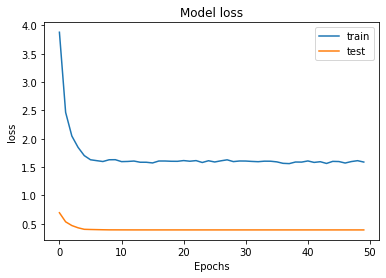

In [ ]:
plot_history(loss_history, loss='True')

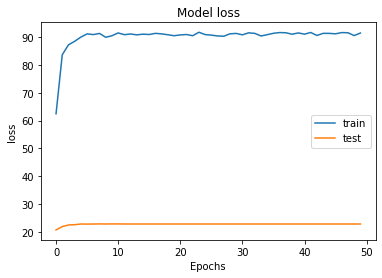

In [ ]:
plot_history(accuracy_history, loss='False')

#### vgg19

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 24.10s
VAL ===> Time: 0.0m 7.57s
Epoch: 1/20, Train Loss: 2.2170, Train Accuracy: %81.931, Val Loss: 0.3405, Val Accuracy: %23.0938
TRAIN ===> Time: 0.0m 21.77s
VAL ===> Time: 0.0m 7.47s
Epoch: 2/20, Train Loss: 1.5508, Train Accuracy: %90.087, Val Loss: 0.3139, Val Accuracy: %23.5312
TRAIN ===> Time: 0.0m 22.09s
VAL ===> Time: 0.0m 7.50s
Epoch: 3/20, Train Loss: 1.4153, Train Accuracy: %92.115, Val Loss: 0.3048, Val Accuracy: %23.5938
TRAIN ===> Time: 0.0m 22.33s
VAL ===> Time: 0.0m 7.88s
Epoch: 4/20, Train Loss: 1.2657, Train Accuracy: %93.369, Val Loss: 0.2896, Val Accuracy: %23.9062
TRAIN ===> Time: 0.0m 22.30s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
VAL ===> Time: 0.0m 5.37s
Epoch: 5/20, Train Loss: 1.2434, Train Accuracy: %93.459, Val Loss: 0.2954, Val Accuracy: %23.9375
TRAIN ===> Time: 0.0m 22.27s
VAL ===> Time: 0.0m 7.62s
Epoch: 6/20, Train Loss: 1.1079, Train Accuracy: %95.397, Val Loss: 0.2874, Val Accuracy: %24.0000
TRAIN ===> Tim

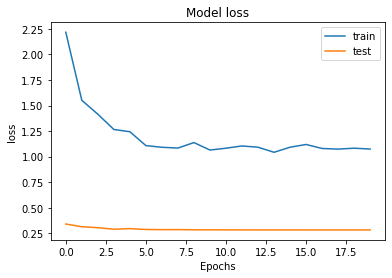

In [ ]:
plot_history(loss_history, loss='True')

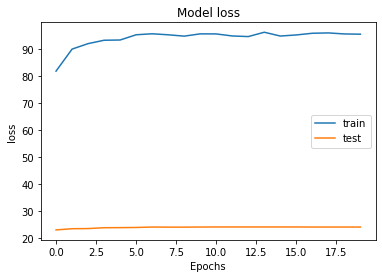

In [ ]:
plot_history(accuracy_history, loss='False')

#### GoogleNet

In [ ]:
model, loss_history, accuracy_history = train_val(googlenet, googlenet_params, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 4.58s
VAL ===> Time: 0.0m 1.24s
Epoch: 1/50, Train Loss: 5.0446, Train Accuracy: %43.749, Val Loss: 1.1143, Val Accuracy: %16.8438
TRAIN ===> Time: 0.0m 4.10s
VAL ===> Time: 0.0m 1.28s
Epoch: 2/50, Train Loss: 4.2431, Train Accuracy: %67.787, Val Loss: 0.9365, Val Accuracy: %20.1875
TRAIN ===> Time: 0.0m 4.12s
VAL ===> Time: 0.0m 1.27s
Epoch: 3/50, Train Loss: 3.6746, Train Accuracy: %77.828, Val Loss: 0.8101, Val Accuracy: %21.8750
TRAIN ===> Time: 0.0m 4.12s
VAL ===> Time: 0.0m 1.27s
Epoch: 4/50, Train Loss: 3.2579, Train Accuracy: %82.415, Val Loss: 0.7184, Val Accuracy: %22.2812
TRAIN ===> Time: 0.0m 4.14s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 1.27s
Epoch: 5/50, Train Loss: 2.9742, Train Accuracy: %84.112, Val Loss: 0.6508, Val Accuracy: %22.5312
TRAIN ===> Time: 0.0m 4.14s
VAL ===> Time: 0.0m 1.28s
Epoch: 6/50, Train Loss: 2.8225, Train Accuracy: %85.421, Val Loss: 0.6431, Val Accuracy: %22.6250
TRAIN ===> Time: 0.0

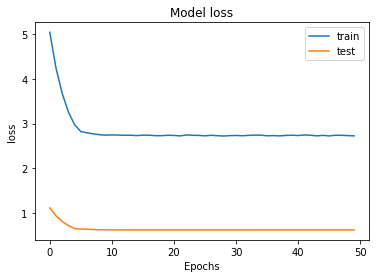

In [ ]:
plot_history(loss_history, loss='True')

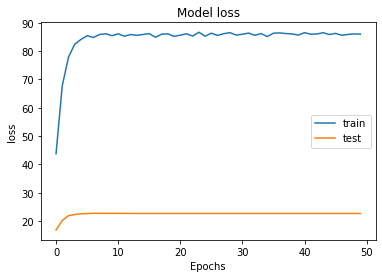

In [ ]:
plot_history(accuracy_history, loss='False')

#### ResNet50

In [ ]:
model, loss_history, accuracy_history = train_val(resnet50, resnet50_params, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 11.25s
VAL ===> Time: 0.0m 2.91s
Epoch: 1/30, Train Loss: 4.4410, Train Accuracy: %59.703, Val Loss: 0.8751, Val Accuracy: %19.7500
TRAIN ===> Time: 0.0m 10.81s
VAL ===> Time: 0.0m 2.91s
Epoch: 2/30, Train Loss: 3.0982, Train Accuracy: %84.675, Val Loss: 0.6542, Val Accuracy: %22.3125
TRAIN ===> Time: 0.0m 10.89s
VAL ===> Time: 0.0m 2.91s
Epoch: 3/30, Train Loss: 2.4755, Train Accuracy: %89.365, Val Loss: 0.5431, Val Accuracy: %22.7500
TRAIN ===> Time: 0.0m 10.98s
VAL ===> Time: 0.0m 2.92s
Epoch: 4/30, Train Loss: 2.1282, Train Accuracy: %91.178, Val Loss: 0.4774, Val Accuracy: %22.9688
TRAIN ===> Time: 0.0m 11.00s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 2.97s
Epoch: 5/30, Train Loss: 1.9054, Train Accuracy: %92.397, Val Loss: 0.4340, Val Accuracy: %23.2500
TRAIN ===> Time: 0.0m 11.09s
VAL ===> Time: 0.0m 3.00s
Epoch: 6/30, Train Loss: 1.7970, Train Accuracy: %93.303, Val Loss: 0.4218, Val Accuracy: %23.4062
TRAIN ===> Tim

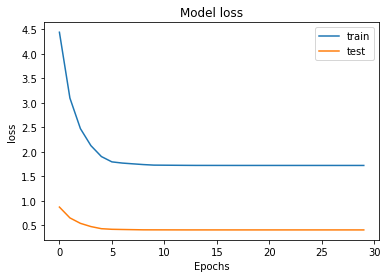

In [ ]:
plot_history(loss_history, loss='True')

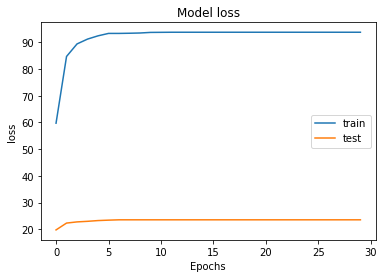

In [ ]:
plot_history(accuracy_history, loss='False')

#### EfficentNet B2

In [ ]:
model, loss_history, accuracy_history = train_val(efficientnetb2, efficientnetb2_params, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 7.79s
VAL ===> Time: 0.0m 1.99s
Epoch: 1/30, Train Loss: 4.7851, Train Accuracy: %56.324, Val Loss: 1.0655, Val Accuracy: %19.4062
TRAIN ===> Time: 0.0m 7.46s
VAL ===> Time: 0.0m 1.97s
Epoch: 2/30, Train Loss: 3.8505, Train Accuracy: %80.196, Val Loss: 0.8797, Val Accuracy: %21.6250
TRAIN ===> Time: 0.0m 7.50s
VAL ===> Time: 0.0m 1.98s
Epoch: 3/30, Train Loss: 3.2400, Train Accuracy: %86.953, Val Loss: 0.7569, Val Accuracy: %22.4375
TRAIN ===> Time: 0.0m 7.51s
VAL ===> Time: 0.0m 1.98s
Epoch: 4/30, Train Loss: 2.8457, Train Accuracy: %87.543, Val Loss: 0.6704, Val Accuracy: %22.8125
TRAIN ===> Time: 0.0m 7.54s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 2.04s
Epoch: 5/30, Train Loss: 2.5556, Train Accuracy: %89.293, Val Loss: 0.6090, Val Accuracy: %23.0000
TRAIN ===> Time: 0.0m 7.56s
VAL ===> Time: 0.0m 2.03s
Epoch: 6/30, Train Loss: 2.4133, Train Accuracy: %90.227, Val Loss: 0.6011, Val Accuracy: %23.0000
TRAIN ===> Time: 0.0

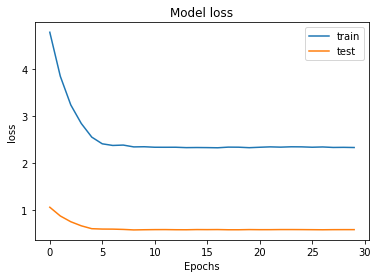

In [ ]:
plot_history(loss_history, loss='True')

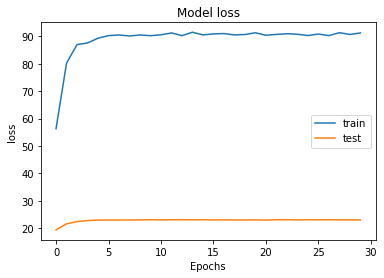

In [ ]:
plot_history(accuracy_history, loss='False')

### 7.Fine-Tuning

##### First Part
As you can see, these models didn't work good on the validation dataset, so let's find the ways to reduce the overfitting

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, requires_grad_param=True, trainable_layers=20)

TRAIN ===> Time: 0.0m 24.09s
Epoch 00021: reducing learning rate of group 0 to 1.0000e-08.
VAL ===> Time: 0.0m 7.56s
Epoch: 1/20, Train Loss: 1.0836, Train Accuracy: %95.434, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 21.83s
VAL ===> Time: 0.0m 5.25s
Epoch: 2/20, Train Loss: 1.0698, Train Accuracy: %95.212, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.08s
VAL ===> Time: 0.0m 5.58s
Epoch: 3/20, Train Loss: 1.0754, Train Accuracy: %95.456, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.63s
VAL ===> Time: 0.0m 7.57s
Epoch: 4/20, Train Loss: 1.0844, Train Accuracy: %95.365, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.42s
VAL ===> Time: 0.0m 5.36s
Epoch: 5/20, Train Loss: 1.0861, Train Accuracy: %95.518, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.26s
VAL ===> Time: 0.0m 5.40s
Epoch: 6/20, Train Loss: 1.0521, Train Accuracy: %96.115, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Tim

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, requires_grad_param=True, trainable_layers=50)

TRAIN ===> Time: 0.0m 24.84s
VAL ===> Time: 0.0m 7.70s
Epoch: 1/20, Train Loss: 1.0628, Train Accuracy: %96.428, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.29s
VAL ===> Time: 0.0m 7.61s
Epoch: 2/20, Train Loss: 1.0862, Train Accuracy: %95.931, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.48s
VAL ===> Time: 0.0m 7.73s
Epoch: 3/20, Train Loss: 1.0808, Train Accuracy: %95.744, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.37s
VAL ===> Time: 0.0m 7.65s
Epoch: 4/20, Train Loss: 1.1082, Train Accuracy: %95.556, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.50s
VAL ===> Time: 0.0m 7.81s
Epoch: 5/20, Train Loss: 1.0852, Train Accuracy: %95.397, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.49s
VAL ===> Time: 0.0m 5.46s
Epoch: 6/20, Train Loss: 1.0800, Train Accuracy: %95.640, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.67s
VAL ===> Time: 0.0m 5.64s
Epoch: 7/20, Train Lo

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, requires_grad_param=True, trainable_layers=100)

TRAIN ===> Time: 0.0m 23.69s
VAL ===> Time: 0.0m 7.55s
Epoch: 1/20, Train Loss: 1.0649, Train Accuracy: %95.865, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 21.63s
VAL ===> Time: 0.0m 7.44s
Epoch: 2/20, Train Loss: 1.0534, Train Accuracy: %96.143, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 21.88s
VAL ===> Time: 0.0m 7.50s
Epoch: 3/20, Train Loss: 1.0729, Train Accuracy: %95.619, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.26s
VAL ===> Time: 0.0m 5.31s
Epoch: 4/20, Train Loss: 1.0936, Train Accuracy: %95.772, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.26s
VAL ===> Time: 0.0m 5.35s
Epoch: 5/20, Train Loss: 1.0577, Train Accuracy: %96.053, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.26s
VAL ===> Time: 0.0m 7.64s
Epoch: 6/20, Train Loss: 1.0980, Train Accuracy: %94.606, Val Loss: 0.2828, Val Accuracy: %24.1562
TRAIN ===> Time: 0.0m 22.33s
VAL ===> Time: 0.0m 5.41s
Epoch: 7/20, Train Lo

##### second part
As you can see, there isn't any improve on the validation set accuracy, so I will use more train data and ignore the Notice I've mentioned above.

I've figured out the problem, The Model's Biggest Error is Classical Overfitting.


### Classical Overfitting
It happens when your model has more parameters than your actual dataset.
In my model, I have 139,601,733 parameters but there are only 11655 images in The Dataset.

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, requires_grad_param=False, trainable_layers=0)

TRAIN ===> Time: 1.0m 21.41s
VAL ===> Time: 0.0m 10.85s
Epoch: 1/50, Train Loss: 7.2557, Train Accuracy: %279.451, Val Loss: 0.6286, Val Accuracy: %33.7188
TRAIN ===> Time: 1.0m 16.22s
VAL ===> Time: 0.0m 10.67s
Epoch: 2/50, Train Loss: 6.0471, Train Accuracy: %294.969, Val Loss: 0.5626, Val Accuracy: %34.6875
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
TRAIN ===> Time: 1.0m 17.75s
VAL ===> Time: 0.0m 11.29s
Epoch: 3/50, Train Loss: 5.7561, Train Accuracy: %297.406, Val Loss: 0.5634, Val Accuracy: %34.8438
TRAIN ===> Time: 1.0m 20.61s
VAL ===> Time: 0.0m 11.20s
Epoch: 4/50, Train Loss: 5.2157, Train Accuracy: %303.607, Val Loss: 0.5299, Val Accuracy: %35.2500
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
TRAIN ===> Time: 1.0m 20.42s
VAL ===> Time: 0.0m 11.13s
Epoch: 5/50, Train Loss: 5.1369, Train Accuracy: %305.388, Val Loss: 0.5226, Val Accuracy: %35.2500
TRAIN ===> Time: 1.0m 20.47s
VAL ===> Time: 0.0m 11.13s
Epoch: 6/50, Train Loss: 5.0254, Train A

In [ ]:
import torchsummary

torchsummary.summary(vgg19_bn, (3, 220, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 220, 220]           1,792
       BatchNorm2d-2         [-1, 64, 220, 220]             128
              ReLU-3         [-1, 64, 220, 220]               0
            Conv2d-4         [-1, 64, 220, 220]          36,928
       BatchNorm2d-5         [-1, 64, 220, 220]             128
              ReLU-6         [-1, 64, 220, 220]               0
         MaxPool2d-7         [-1, 64, 110, 110]               0
            Conv2d-8        [-1, 128, 110, 110]          73,856
       BatchNorm2d-9        [-1, 128, 110, 110]             256
             ReLU-10        [-1, 128, 110, 110]               0
           Conv2d-11        [-1, 128, 110, 110]         147,584
      BatchNorm2d-12        [-1, 128, 110, 110]             256
             ReLU-13        [-1, 128, 110, 110]               0
        MaxPool2d-14          [-1, 128,

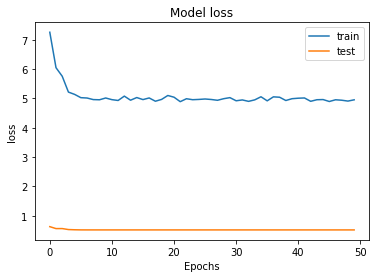

In [ ]:
plot_history(loss_history, loss='True')

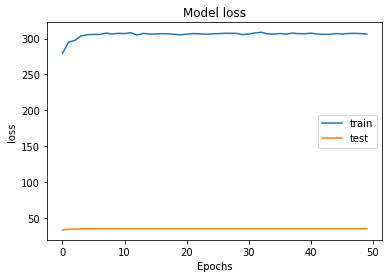

In [ ]:
plot_history(accuracy_history, loss='False')

##Part 2
Since my efforts in part 1 didn't make effect the training process, I will use another models that are more suitable to this task